# Algoritmo de Shor - Fatorando 65535 em um dispositivo real


## - Implementando circuitos genéricos de apenas um número inteiro como entrada


### O dispositivo disponível com o maior numero de qubits é o ibmq_16_melbourne. Neste notebook veremos que tal dispositivo apresentou excelentes resultados na fatoração do número 65535 (maior possível para essa quantidade de qubits.)

In [1]:
import qiskit
from qiskit import *
from qiskit.visualization import *
import numpy as np

In [2]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
from qiskit.visualization import plot_histogram

In [3]:
from math import*
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT




#### Basta escolher o m para que todos os outros parâmetros sejam gerados automaticamente.

In [4]:
m=4 #entre com qualquer valor de m>0
reg1 = 2
reg2=4+3*(m-1)
n=reg1+reg2
M = 2**(4*m) - 1
a=2**m

print('Número de Mersenne a ser fatorado = ', M)
print('palpite inicial a = ', a)
print('Número de qubits necessários no reg2 = ',reg2)
print('Número de qubits necessários no reg1 = ',reg1)

Número de Mersenne a ser fatorado =  65535
palpite inicial a =  16
Número de qubits necessários no reg2 =  13
Número de qubits necessários no reg1 =  2








#### Abaixo, o circuito é implementado de acordo com o valor de m. Repare que os valores reg1 e n são sempre os mesmos (reg1=2 e n=reg1+reg2)

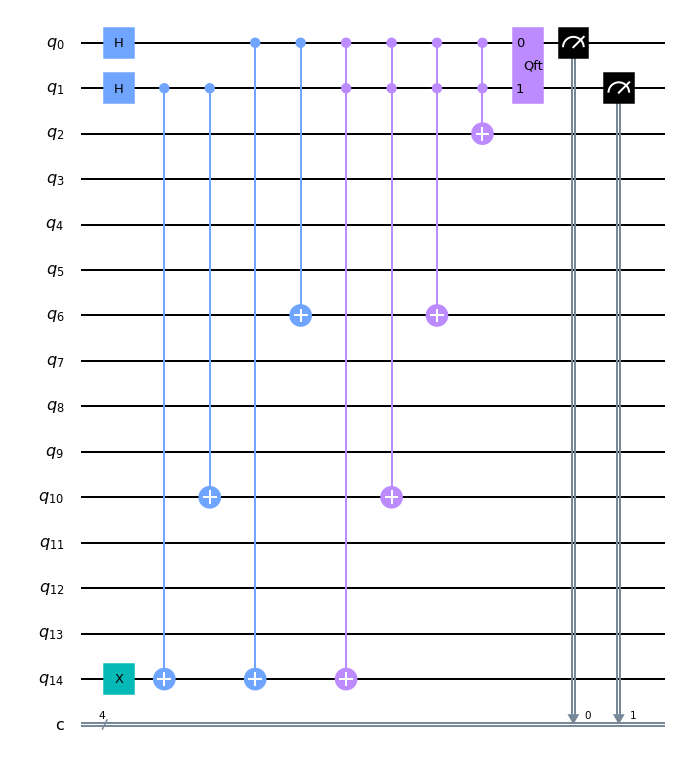

In [5]:
shor = QuantumCircuit(n,reg1+2)

shor.h(range(reg1))
shor.x(n-1)

shor.cx(1,n-1)
shor.cx(1, n-1-m)

shor.cx(0,n-1)
shor.cx(0, n-1-2*m)


shor.toffoli(0,1,n-1)
shor.toffoli(0,1,n-1-m)
shor.toffoli(0,1,n-1-2*m)
shor.toffoli(0,1,2)

shor.append(QFT(reg1 , approximation_degree = reg1, do_swaps=False, inverse=True), range(reg1))

shor.measure(range(reg1),range(reg1))

shor.draw(output='mpl', fold=-1)

### Resultado no Simulador

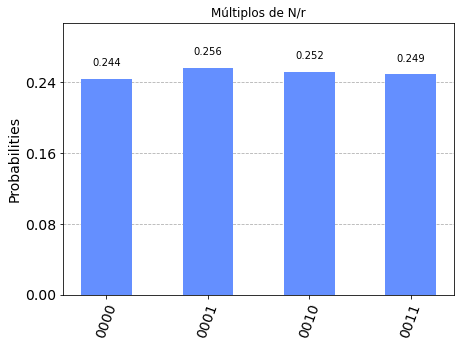

In [6]:
counts = execute(shor, backend=simulator, shots=10000).result().get_counts(shor) 
plot_histogram(counts, title='Múltiplos de N/r')

In [7]:
for measured_value in counts:
    print(f"Medido: {int(measured_value[::-1], 2)}")

Medido: 0
Medido: 8
Medido: 4
Medido: 12


In [8]:
from math import gcd

for measured_value in counts:
    valor_decimal_medido = int(measured_value[::-1], 2)
    print(f"Valor Medido: {valor_decimal_medido}")
    
    if valor_decimal_medido % 2 != 0:
        print("Valor medido não é par")
        continue
    x = int((a ** (valor_decimal_medido/2)) % M)
    if (x + 1) % M == 0:
        print("Falha. x + 1 = 0 (mod N) onde x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, M), gcd(x - 1, M)
    print(guesses)

Valor Medido: 0
(1, 65535)
Valor Medido: 8
(1, 65535)
Valor Medido: 4
(257, 255)
Valor Medido: 12
(257, 255)


### Resultado no ibmq_16_melbourne

In [9]:
provider = IBMQ.enable_account('fc468db54b8e5b00bcf2963de18ca2d7315ec9f207794681b8026fe12c80f2cd5c88b24dd2697a9bef080dca3cc07aa73f14dbfb0042b7bb5073d510f3344a0d')
backends = provider.backends()
device = provider.get_backend('ibmq_16_melbourne')

C:\Users\ANDROS\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [10]:
counts2 = execute(shor, backend=device, shots=2048).result().get_counts(shor)


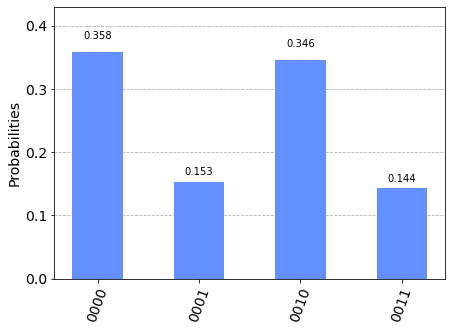

In [11]:
plot_histogram(counts2)

In [12]:
for measured_value in counts2:
    print(f"Medido: {int(measured_value[::-1], 2)}")

Medido: 0
Medido: 8
Medido: 4
Medido: 12


In [13]:
from math import gcd

for measured_value in counts2:
    valor_decimal_medido = int(measured_value[::-1], 2)
    print(f"Valor Medido: {valor_decimal_medido}")
    
    if valor_decimal_medido % 2 != 0:
        print("Valor medido não é par")
        continue
    x = int((a ** (valor_decimal_medido/2)) % M)
    if (x + 1) % M == 0:
        print("Falha. x + 1 = 0 (mod N) onde x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, M), gcd(x - 1, M)
    print(guesses)

Valor Medido: 0
(1, 65535)
Valor Medido: 8
(1, 65535)
Valor Medido: 4
(257, 255)
Valor Medido: 12
(257, 255)




## Adaptando o algoritmo acima para o modelo de Kitaev

In [14]:
kitaev = QuantumCircuit(reg1+reg2, reg1+2)
qc1, qc2, qc3, qc4 = [QuantumCircuit(reg2),QuantumCircuit(reg2),QuantumCircuit(reg2),QuantumCircuit(reg2)]

U1 = qc1.to_gate().control(1)

qc2.x([reg2-1, reg2-1-m])
U2 = qc2.to_gate().control(1)

qc3.x([reg2-1,reg2-1-2*m])
U3 = qc3.to_gate().control(1)

qc4.x([reg2-1,reg2-1-m,reg2-1-2*m,reg2-1-3*m])
U4 = qc4.to_gate().control(2)

kitaev.x(n-1)
kitaev.h(range(reg1))
kitaev.barrier()


lista = []
for i in range(n):
    lista.append(i)
lista.remove(1)

kitaev.append(U2, range(1,n))
kitaev.append(U3, lista)
kitaev.append(U4, range(0,n))

kitaev.barrier()
kitaev.append(QFT(reg1 , approximation_degree = reg1, do_swaps=False, inverse=True), range(reg1))

kitaev.measure(range(reg1),range(reg1))


### Desenho do circuito

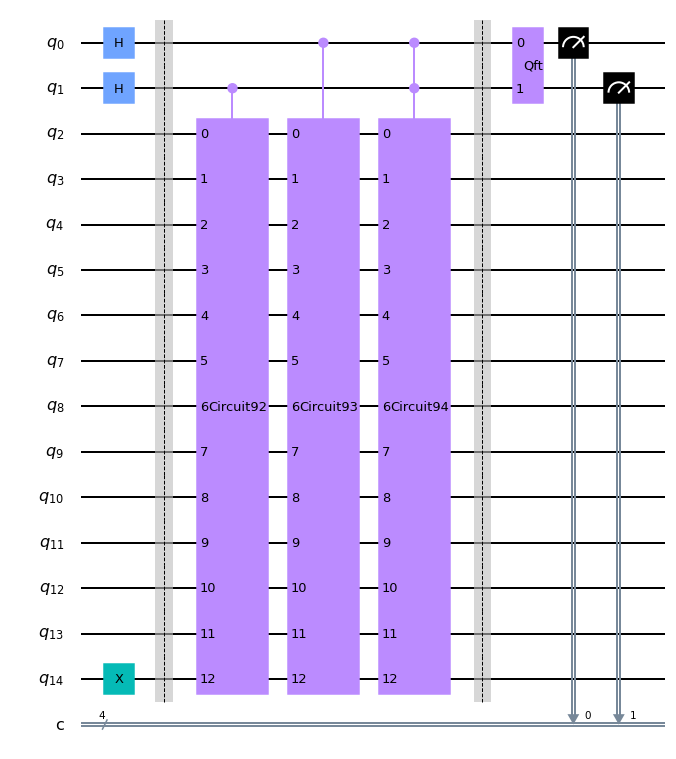

In [25]:
kitaev.draw(output='mpl')

In [16]:
counts_kitaev = execute(kitaev, backend=simulator, shots=10000).result().get_counts(kitaev) 



In [17]:
for measured_value in counts_kitaev:
    print(f"Medido: {int(measured_value[::-1], 2)}")

Medido: 0
Medido: 8
Medido: 4
Medido: 12


In [18]:
for measured_value in counts_kitaev:
    valor_decimal_medido = int(measured_value[::-1], 2)
    print(f"Valor Medido: {valor_decimal_medido}")
    
    if valor_decimal_medido % 2 != 0:
        print("Valor medido não é par")
        continue
    x = int((a ** (valor_decimal_medido/2)) % M)
    if (x + 1) % M == 0:
        print("Falha. x + 1 = 0 (mod N) onde x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, M), gcd(x - 1, M)
    print(guesses)

Valor Medido: 0
(1, 65535)
Valor Medido: 8
(1, 65535)
Valor Medido: 4
(257, 255)
Valor Medido: 12
(257, 255)


In [19]:
257*255

65535

### Resultados no ibmq_16_melbourne para o modelo de Kitaev

In [20]:
counts_kitaev = execute(kitaev, backend=device, shots=2048).result().get_counts(kitaev)

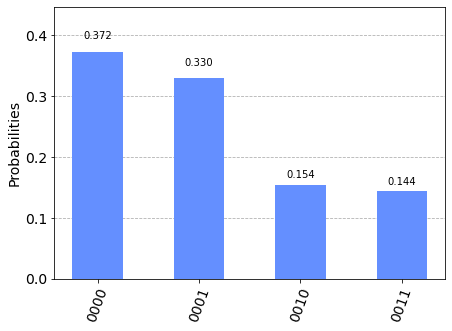

In [21]:
plot_histogram(counts_kitaev)

In [22]:
for measured_value in counts_kitaev:
    print(f"Medido: {int(measured_value[::-1], 2)}")

Medido: 0
Medido: 8
Medido: 4
Medido: 12


### Parte clássica

In [23]:
for measured_value in counts_kitaev:
    valor_decimal_medido = int(measured_value[::-1], 2)
    print(f"Valor Medido: {valor_decimal_medido}")
    
    if valor_decimal_medido % 2 != 0:
        print("Valor medido não é par")
        continue
    x = int((a ** (valor_decimal_medido/2)) % M)
    if (x + 1) % M == 0:
        print("Falha. x + 1 = 0 (mod N) onde x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, M), gcd(x - 1, M)
    print(guesses)

Valor Medido: 0
(1, 65535)
Valor Medido: 8
(1, 65535)
Valor Medido: 4
(257, 255)
Valor Medido: 12
(257, 255)


In [24]:
257*255

65535

vemos que os fatores do numero 65535 foram encontrados corretamente.